## Import libraries, methods and constants

In [1]:
import numpy as np
import json
import torch
import matplotlib.pyplot as plt
import os
from os import sys

In [2]:
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from config import model_types, crops

## Check if GPU is detected

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
print(device)

cpu


## Analyze model performance

In [4]:
def preprocess_model_performance_info_for_model(model_folder):
    train_runtimes = {}
    eval_runtimes = {}
    epochs = {}
    train_losses = {}
    eval_losses = {}

    for model_type in model_types:
        train_runtimes[model_type] = {}
        eval_runtimes[model_type] = {}
        epochs[model_type] = {}
        train_losses[model_type] = {}
        eval_losses[model_type] = {}

        for crop in crops:
            with open('../' + model_folder + '/' + model_type + '/' + crop + '/log_history.json', 'r') as file:
                data = json.load(file)
                
                train_runtimes[model_type][crop] = data[-1]['train_runtime']
                epochs[model_type][crop] = data[-1]['epoch']

                eval_runtimes[model_type][crop] = []
                train_losses[model_type][crop] = []
                eval_losses[model_type][crop] = []
                for entry in data:
                    if 'eval_runtime' in entry.keys():
                        eval_runtimes[model_type][crop].append(entry['eval_runtime'])

                    if 'eval_loss' in entry.keys():
                        eval_losses[model_type][crop].append(entry['eval_loss'])

                    if 'train_loss' in entry.keys():
                        train_losses[model_type][crop].append(entry['train_loss'])

    return train_runtimes, eval_runtimes, epochs, train_losses, eval_losses

In [5]:
def compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses):
    # Total runtime
    train_runtime_total = 0
    eval_runtime_total = 0

    # train_runtime_per_model_type = {}
    # eval_runtime_per_model_type = {}

    for model_type in model_types:
        # train_runtime_per_model_type[model_type] = 0
        # eval_runtime_per_model_type[model_type] = 0

        for crop in crops:
            train_runtime_total = train_runtime_total + train_runtimes[model_type][crop]
            eval_runtime_total = eval_runtime_total + sum(eval_runtimes[model_type][crop])

            # train_runtime_per_model_type[model_type] = train_runtime_per_model_type[model_type] + train_runtimes[model_type][crop]
            # eval_runtime_per_model_type[model_type] = eval_runtime_per_model_type[model_type] + eval_runtimes[model_type][crop]
            

    print('Total training time in h: ' + str(train_runtime_total/60/60))
    print('Total evaluation time in h: ' + str(eval_runtime_total/60/60))

In [6]:
def plot_bar_chart(data, title):
    # Extract the labels and values for the 'binary' and 'multiclass' categories
    crops = list(data['binary'].keys())
    binary_values = [data['binary'][crop] for crop in crops]
    multiclass_values = [data['multiclass'][crop] for crop in crops]

    # Set the width of the bars
    bar_width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bar positions for each category
    x = range(len(crops))

    # Plot the 'binary' values
    plt.bar(x, binary_values, width=bar_width, label='Binary', align='center')

    # Plot the 'multiclass' values with an offset
    plt.bar([i + bar_width for i in x], multiclass_values, width=bar_width, label='Multiclass', align='center')

    plt.title(title)
    crop_labels = [crop.replace("_", " ") for crop in crops]
    plt.xticks([i + bar_width / 2 for i in x], crop_labels, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

In [7]:
def plot_heat_map(data, title):
    categories = list(data.keys())

    # Convert the data to a NumPy array
    heatmap_data = np.array([[data[category][crop] for crop in crops] for category in categories])

    fig, ax = plt.subplots(figsize=(10, 6))
    # Create the heatmap
    cax = ax.matshow(heatmap_data, cmap='viridis')

    # Add colorbar
    cbar = fig.colorbar(cax)

    # Set labels for the x and y axes
    labels = [crop.replace("_", " ") for crop in list(data['binary'].keys())]
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(categories)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(categories)

    # Show the values in each cell
    # for i in range(len(categories)):
    #     for j in range(len(items)):
    #         text = ax.text(j, i, f'{heatmap_data[i, j]:.2f}', ha='center', va='center', color='w', fontsize=8)  # Specify fontsize
    plt.title('Heatmap of Values for Different Categories and Items')
    plt.tight_layout()
    plt.show()

In [8]:
train_runtimes, eval_runtimes, epochs, train_losses, eval_losses = preprocess_model_performance_info_for_model('models-3-patience')
epochs

{'binary': {'broad_bean': 10.83,
  'common_buckwheat': 28.64,
  'pea': 8.87,
  'corn': 8.37,
  'soybean': 3.12,
  'sunflower': 20.31,
  'sugar_beet': 16.7},
 'multiclass': {'broad_bean': 17.5,
  'common_buckwheat': 9.09,
  'pea': 16.9,
  'corn': 19.88,
  'soybean': 4.68,
  'sunflower': 9.69,
  'sugar_beet': 4.77}}

In [9]:
compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses)

Total training time in h: 15.726029638888889
Total evaluation time in h: 7.5579040000000015


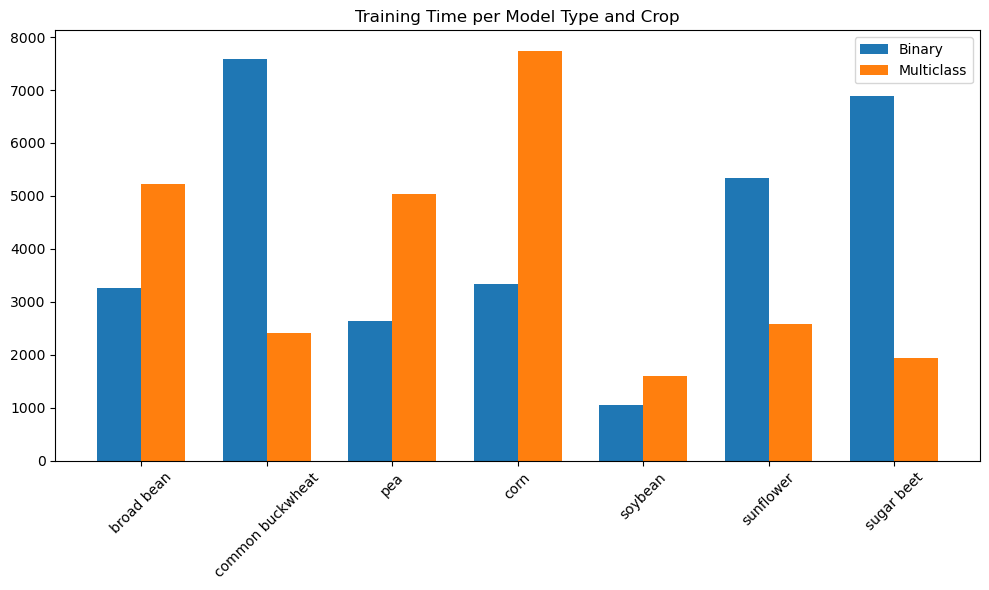

In [10]:
plot_bar_chart(train_runtimes, 'Training Time per Model Type and Crop')

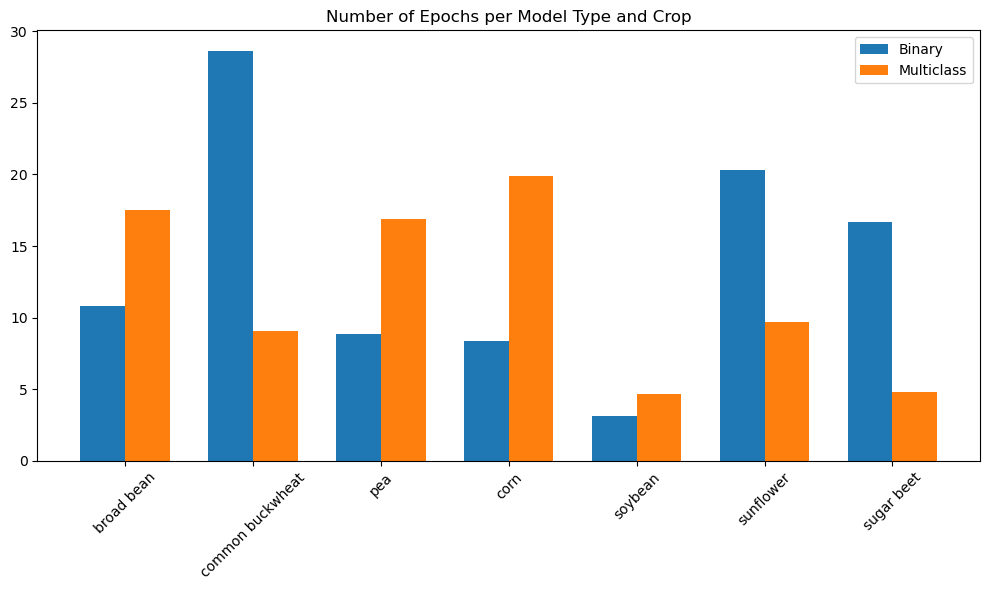

In [11]:
plot_bar_chart(epochs, 'Number of Epochs per Model Type and Crop')

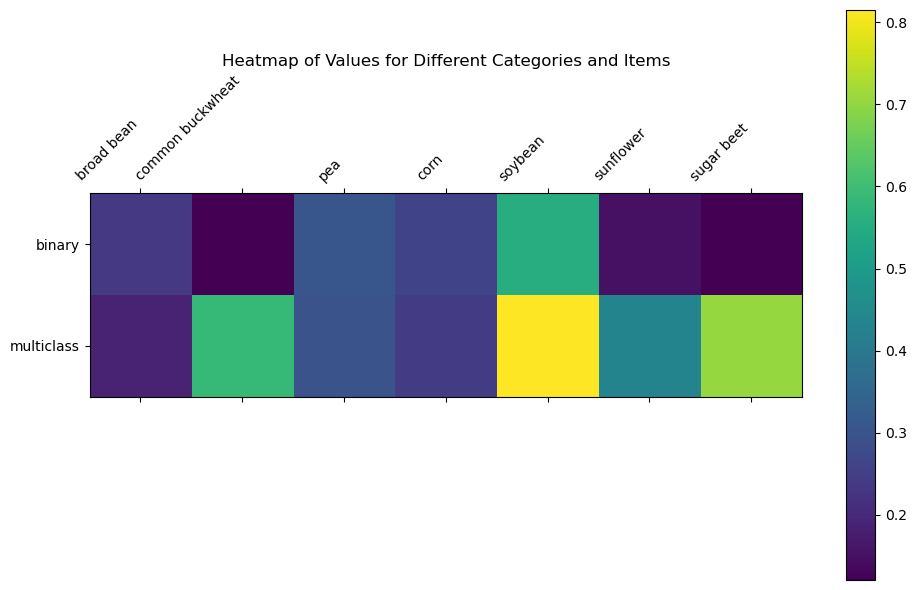

In [12]:
plot_heat_map(train_losses, 'Train Loss Heatmap per Model Type and Crop')

In [18]:
def plot_line_graph(data, title):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Loop through the categories and items to plot lines
    for category, item_data in data.items():
        for item, values in item_data.items():
            print(item)
            print(values)
            label = f'{category} - {item}'
            x = np.arange(len(values))
            ax.plot(x, values, label=label)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Values')

    plt.title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [19]:
train_losses

{'binary': {'broad_bean': [0.2361176785750267],
  'common_buckwheat': [0.12322792340336101],
  'pea': [0.30719266532668993],
  'corn': [0.2612994092490731],
  'soybean': [0.5523112377772729],
  'sunflower': [0.15263819639909673],
  'sugar_beet': [0.12067911673280202]},
 'multiclass': {'broad_bean': [0.19030386587634446],
  'common_buckwheat': [0.5854673550029595],
  'pea': [0.2980339138124449],
  'corn': [0.24068963281423594],
  'soybean': [0.8148393312676085],
  'sunflower': [0.43445453531153144],
  'sugar_beet': [0.705931080806823]}}

broad_bean
[0.2361176785750267]
common_buckwheat
[0.12322792340336101]
pea
[0.30719266532668993]
corn
[0.2612994092490731]
soybean
[0.5523112377772729]
sunflower
[0.15263819639909673]
sugar_beet
[0.12067911673280202]
broad_bean
[0.19030386587634446]
common_buckwheat
[0.5854673550029595]
pea
[0.2980339138124449]
corn
[0.24068963281423594]
soybean
[0.8148393312676085]
sunflower
[0.43445453531153144]
sugar_beet
[0.705931080806823]


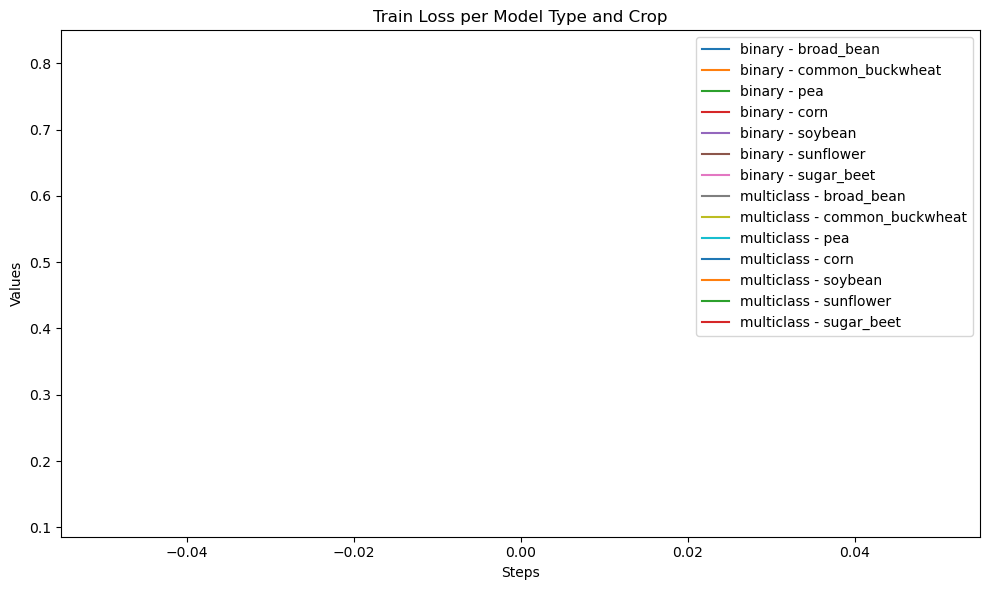

In [20]:
plot_line_graph(train_losses, 'Train Loss per Model Type and Crop')

broad_bean
[1.2633179426193237, 0.8783859014511108, 0.5039825439453125, 0.41332849860191345, 0.3380838632583618, 0.2583097517490387, 0.2599591910839081, 0.15176081657409668, 0.14514267444610596, 0.1442948430776596, 0.10396070778369904, 0.10072078555822372, 0.0979829803109169, 0.11531946063041687, 0.06340353190898895, 0.039252571761608124, 0.08933458477258682, 0.04532190412282944, 0.03205020725727081, 0.028747865930199623, 0.047288764268159866, 0.04382138326764107, 0.024551628157496452, 0.03397945314645767, 0.029555311426520348, 0.04023974761366844]
common_buckwheat
[1.3852840662002563, 1.022204041481018, 0.6784955859184265, 0.4635881781578064, 0.4341932535171509, 0.3640064299106598, 0.2997843623161316, 0.26678717136383057, 0.21562780439853668, 0.18417754769325256, 0.1743224412202835, 0.10399565100669861, 0.10312525928020477, 0.07347619533538818, 0.06370192766189575, 0.061099082231521606, 0.0526699423789978, 0.06282136589288712, 0.053504303097724915, 0.04508119821548462, 0.0437225624918

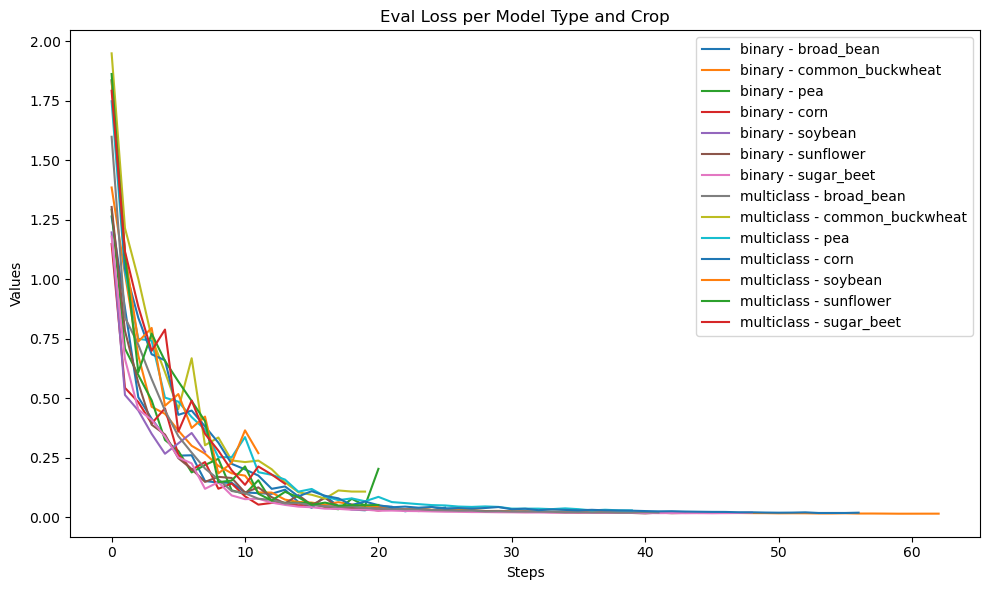

In [21]:
plot_line_graph(eval_losses, 'Eval Loss per Model Type and Crop')